In [1]:
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import dataloader
import matplotlib.pyplot as plt

In [2]:
# Function to convert the Python dictionary loaded in by the dataloader.py load_data function 
# into a NumPy matrix for downstream manipulation
# Params:
# image_dict - Python dictionary with facial expressions as keys and a list NumPy arrays representing
#              image as values
# Return: A NumPy matrix of dimensions dxM denoting M images of d dimensions
def get_matrix(image_dict):
    image_matrix = []
    for emotion in image_dict:
        for image in image_dict[emotion]:
            image_matrix.append(np.concatenate(image))
    return np.matrix(image_matrix).T

In [3]:
# Function to apply PCA to a dxM image matrix, with M images each of dimension d
# Params:
# image_matrix - a dxM matrix representing M images each of dimension d (output of get_matrix)
# Return: the eigenvalues and principal components of the covariance matrix of the input
# eig_vals - the M eigenvalues of the MxM covariance matrix
# pcs - the M dx1 eigenvectors of the covariance matrix in the form of a dxM matrix
# Return: the M eigenvalues and M pcs from the covariance matrix calculated via PCA
def principal_components(image_matrix):
    mean_face = np.matrix.mean(image_matrix, axis = 1)
    centered_matrix = image_matrix - mean_face
    covariance_matrix = np.dot(centered_matrix.T, centered_matrix)/centered_matrix.shape[1]
    eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)
    order = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[order]
    eig_vecs = eig_vecs[:,order]
    pcs = centered_matrix*eig_vecs
    return(eig_vals, pcs)

In [4]:
# Function to project a dxM image matrix onto pcs calculate by PCA
# Params:
# mean_face - the average face calculate from averaging pixel values of training set
# image_matrix - the images to project in the from of a dxM matrix
# eig_vals - the eigenvalues calculated from PCA on the training set
# pcs - the pcs calculated from PCA on the training set
# k - the number of dimensions to keep
# Return: the dxM image matrix projected down to the kxM space
def project_k_dimensions(image_matrix, mean_face, eig_vals, pcs, k):
    centered_matrix = image_matrix - mean_face
    projections = centered_matrix.T*pcs[:, 0:k]
    projections = projections/(np.linalg.norm(pcs[:, 0:k], axis = 0))/np.sqrt(eig_vals[0:k])
    return projections.T

In [5]:
#Crossfold validation splitting: 
#INPUT: 1) A dictionary mapping two emotions to an equal number of classes 2) The number of k mutually exclusive sets
#OUTPUT: a dictionary of k mutually exclusive sets where each set contains roughly the same number of each category in each set 
def CrossFold(toBeSplit, howMany):
    toReturn = defaultdict(list)
    targets = defaultdict(list)
    total = len([val for k,v in toBeSplit.items() for val in v])
    midpoint = int((total/howMany)/2)
    remainder = int(total/howMany) - midpoint
    
    keys = [k for k in toBeSplit]
    first = [el for el in toBeSplit[keys[0]]] #images of class 1
    random.shuffle(first) #randomly shuffle images
    second = [el for el in toBeSplit[keys[1]]] #images of class 2 
    random.shuffle(second)
    
    indexOne = 0
    indexTwo = 0
    difference = total % howMany
    for i in range(howMany):
        if difference != 0:
            toReturn[i] = first[indexOne:indexOne+remainder] + second[indexTwo:indexTwo+remainder]
            targets[i] = [0]*remainder + [1]*remainder
            indexOne += remainder
            indexTwo += remainder
            difference = difference -1 
        else:
            if (i%2 == 0):
                toReturn[i] = first[indexOne:indexOne+midpoint] + second[indexTwo:indexTwo+remainder]
                targets[i] = [0]*midpoint + [1]*remainder
                indexOne += midpoint
                indexTwo += remainder
            else:
                toReturn[i] = first[indexOne:indexOne+remainder] + second[indexTwo:indexTwo+midpoint]
                targets[i] = [0]*remainder + [1]*midpoint
                indexOne += remainder
                indexTwo += midpoint
             
    if sum([len(v) for k,v in toReturn.items()]) != total:
        print("We have problems...")
        
    return toReturn, targets

def CheckMutuallyExclusive(areMutuallyExclusive):
    for k,v in areMutuallyExclusive.items():
        #within a fold:
        for i in range(len(v)):
            toBeEvaluated = v[i]
            for j in range(i+1, len(v)):
                if(np.array_equal(toBeEvaluated,v[j])):
                    print("Well this sucks I have redundancies within a fold...")
        #between folds:
        for key,value in areMutuallyExclusive.items():
            if k == key:
                continue
            else:
                for i in range(len(v)):
                    for j in range(len(value)):
                        if np.array_equal(v[i], value[j]):
                            print("Son of a.... there are redundancies between folds")
                    
    return None 


In [6]:
# Essentially a main function to load in whataver data will be applied to PCA
data, cnt = dataloader.load_data('./aligned/')  # Will depend on what data we are loading and training on and holding out
data = dataloader.balanced_sampler(data, cnt, ['anger', 'happiness'])

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
anger: 45 # of images
happiness: 45 # of images


In [7]:
# Display an example image
dataloader.display_face(data['anger'][0])
n1, n2 = data['anger'][0].shape

Converting from array to PIL Image


In [8]:
# Convert to a dxM matrix and calculate eigenvalues and principal components
image_m = get_matrix(data)
eigen_values, eigen_vectors = principal_components(image_m)

In [9]:
# Calculate and display the mean face among the data
mean_image = np.matrix.mean(image_m, axis = 1)
dataloader.display_face(np.array(np.reshape(mean_image, (n1,n2))))

Converting from array to PIL Image


In [12]:
# First sanity check
centered_data = image_m - mean_image
first_projection = centered_data.T*eigen_vectors[:,0]/np.linalg.norm(eigen_vectors[:,0])
print(np.mean(first_projection))
print(np.std(first_projection))
print(np.sqrt(eigen_values[0]))

-2.021099337273174e-14
7045.691937087485
7045.6919370874875


In [13]:
# Second sanity check
norm_first_projection = first_projection/np.sqrt(eigen_values[0])
print(np.mean(norm_first_projection))
print(np.std(norm_first_projection))

-4.934324553889585e-18
0.9999999999999994


In [14]:
# Check 50 PCs
projected_data = project_k_dimensions(image_m, mean_image, eigen_values, eigen_vectors, 50)
print(np.mean(projected_data, axis = 1).T)
print(np.std(projected_data, axis = 1).T)

[[-5.05768267e-17 -4.44089210e-17  3.57738530e-17  1.15956627e-16
   6.53798003e-17  5.67447324e-17 -1.23358114e-18 -4.44089210e-17
  -5.79783135e-17  3.88578059e-17 -4.93432455e-17 -6.35390660e-17
  -3.88578059e-17  7.46316589e-17  3.41740525e-17  1.72701359e-17
  -7.40148683e-18  7.15477060e-17  8.60422844e-17  4.99600361e-17
  -1.27058857e-16  0.00000000e+00 -1.06242176e-16  8.60422844e-17
  -3.08395285e-17 -3.82410153e-17 -9.99200722e-17 -7.40148683e-18
   4.93432455e-18  1.72701359e-17  2.65219945e-17 -3.94745964e-17
   6.66133815e-17  7.28005619e-17 -7.40148683e-18  9.86864911e-18
   6.35294286e-17 -4.62592927e-18 -9.25185854e-18  4.44089210e-17
   1.91205076e-17  1.60365548e-17 -1.23358114e-17  0.00000000e+00
   2.71387850e-17 -4.56425021e-17  4.62592927e-17  6.47630098e-17
  -4.31753398e-17 -2.15876699e-17]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1.]]


In [23]:
# Visualize PCs
# INPUT: 1) Number of principal components (int) 2) Learning Rate (float) 3) The number of k components (int) 4) Number of Epochs (int) 5) emotion (str) 6) emotion (str)
# OUTPUT: Displays the TEST accuracy and loss as well as the VAL/Train normalized loss and accuracy plots as well as the first 4 PCs
def LogRegAligned(howManyPrincipalComponents, alpha, k, numEpochs, firstEmotion, secondEmotion):
    forPartC = "./aligned/"
    dataset, cnt = dataloader.load_data(forPartC)
    images = dataloader.balanced_sampler(dataset, cnt, emotions=[firstEmotion, secondEmotion])
    
    #split into 10 folds
    splitEmUp, labels = CrossFold(images, k) 
    CheckMutuallyExclusive(splitEmUp)
    
    #implement cross validation:
    trainingLoss = []
    validationLoss = []
    testLoss = []

    trainPerformance = []
    valPerformance = []
    testPerformance = []

    for fold in range(k):
        trainData = defaultdict(list)
        trainLabels = []
        valData = defaultdict(list)
        valLabels = []
        testData = defaultdict(list)
        testLabels = []
        counter = 0 
        
        valData["val"] = splitEmUp[fold]
        testData["test"] = splitEmUp[(fold + 1) %k]
        counter = 0
        for key,v in splitEmUp.items():
            if (counter != fold) and (counter != (fold +1) %k):
                for val in v: 
                    trainData["train"].append(val)
                for el in labels[key]:
                    trainLabels.append(el)
                counter += 1
            elif(counter == fold):
                for el in labels[key]:
                    valLabels.append(el)
                counter += 1 
            else:
                for el in labels[key]:
                    testLabels.append(el)
                counter += 1
        
        if len(testLabels) != len(valLabels):
            print("Strange things are happening")
        
        #Perform PCA on train
        trainingMatrix = get_matrix(trainData)
        eig_vals, pcs = principal_components(trainingMatrix)
        mean_face = np.matrix.mean(trainingMatrix, axis = 1)
        
        #project all data onto top p (here howManyPrincipalComponents variable) train PC's scaled
        projectedTrain = project_k_dimensions(mean_face, trainingMatrix, eig_vals, pcs, howManyPrincipalComponents).T
        
        #Plot the first four principal components plotted as images:
        print("First four PCs for fold #" + str(fold+1))
        plt.figure(figsize=(12,12))
        for i in range(4):
            plt.subplot(1,6,i+1)
            plt.title("PC" + str(i+1))
            forPlotting = np.array(np.reshape(pcs[:,i], (images[firstEmotion][0].shape[0], images[firstEmotion][0].shape[1])))
            img = Image.fromarray(forPlotting)
            plt.imshow(img)
            plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
            plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
        plt.show()

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
anger: 45 # of images
happiness: 45 # of images
First Four PCs for fold #0


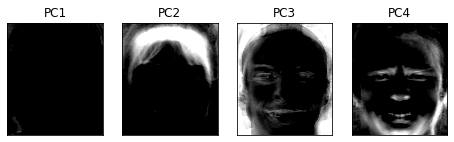

First Four PCs for fold #1


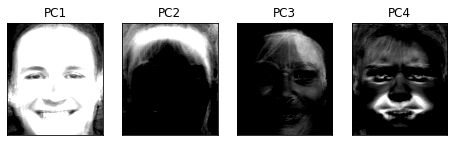

First Four PCs for fold #2


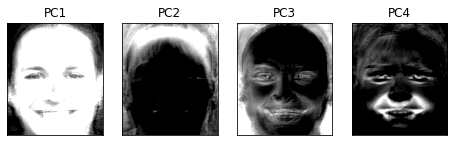

First Four PCs for fold #3


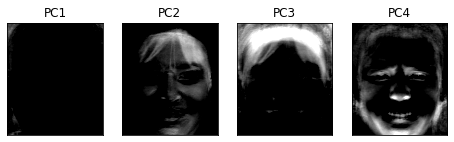

First Four PCs for fold #4


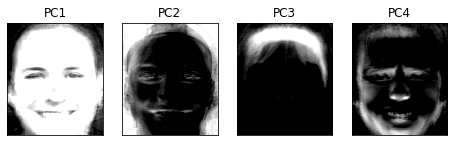

First Four PCs for fold #5


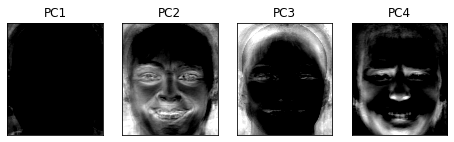

First Four PCs for fold #6


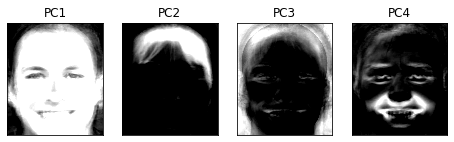

First Four PCs for fold #7


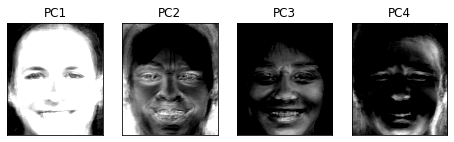

First Four PCs for fold #8


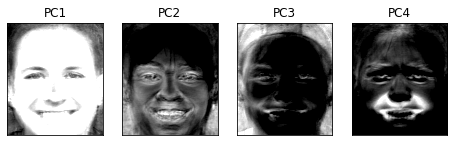

First Four PCs for fold #9


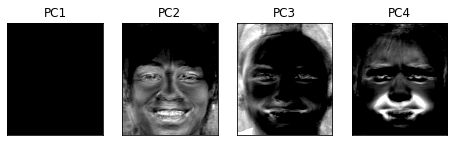

In [24]:
oneLearningRate = LogRegAligned(4, 0.02, 10, 50,'anger', 'happiness')